In [ ]:
from tqdm.notebook import tqdm
import numpy as np

In [ ]:
!git clone https://github.com/tomasmuzas/MasterThesis.git

Cloning into 'MasterThesis'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 114 (delta 47), reused 94 (delta 28), pack-reused 0
Receiving objects: 100% (114/114), 885.10 KiB | 8.05 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
from MasterThesis.read_dataset import *
from MasterThesis.models import *
from MasterThesis.callbacks import *

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
@tf.function
def random_zoom(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = tf.image.crop_to_bounding_box(x, 10, 10, 108, 108)
    x = tf.image.resize(x, (128,128))
  else:
    x
  return x


def read_tf_record_dataset_v2(path, preprocessing_function, image_size, batch_size, augment = False, include_objid = False, drop_remainder = True, grayscale = False):
  filenames = tf.io.gfile.glob(path + "/*.tfrec")
  dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset4 = dataset4.map(lambda x: read_tfrecord(x, image_size), num_parallel_calls=AUTO)
  if (include_objid):
    dataset4 = dataset4.map(lambda image, class_num, label, objid, one_hot_class: (image, class_num, objid))
    if(grayscale):
      dataset4 = dataset4.map(lambda x, y, z: (tf.image.rgb_to_grayscale(x), y, z), num_parallel_calls=AUTO)
    dataset4 = dataset4.map(lambda x, y, z: (tf.cast(x, tf.float32), y, z), num_parallel_calls=AUTO)
    dataset4 = dataset4.map(lambda x, y, z: (preprocessing_function(x), y, z), num_parallel_calls=AUTO)
    if(augment):
      dataset4 = dataset4.map(lambda x,y,z : (random_zoom(x, y), y, z), num_parallel_calls=AUTO)
      dataset4 = dataset4.map(lambda x,y,z : (random_invert_horizontally(x, y), y, z), num_parallel_calls=AUTO)
      dataset4 = dataset4.map(lambda x,y,z : (random_invert_vertically(x, y), y, z), num_parallel_calls=AUTO)
      dataset4 = dataset4.map(lambda x,y,z : (random_rotate(x, y), y, z), num_parallel_calls=AUTO)
      
  else:
    dataset4 = dataset4.map(lambda image, class_num, label, objid, one_hot_class: (image, class_num))
    if(grayscale):
      dataset4 = dataset4.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y), num_parallel_calls=AUTO)
    dataset4 = dataset4.map(lambda x, y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTO)
    dataset4 = dataset4.map(lambda x, y: (preprocessing_function(x), y), num_parallel_calls=AUTO)
    if(augment):
      dataset4 = dataset4.map(lambda x,y : (random_zoom(x, y), y), num_parallel_calls=AUTO)
      dataset4 = dataset4.map(lambda x,y : (random_invert_horizontally(x, y), y), num_parallel_calls=AUTO)
      dataset4 = dataset4.map(lambda x,y : (random_invert_vertically(x, y), y), num_parallel_calls=AUTO)
      dataset4 = dataset4.map(lambda x,y : (random_rotate(x, y), y), num_parallel_calls=AUTO)
      

  return dataset4.batch(batch_size, drop_remainder=drop_remainder).prefetch(AUTO)

In [ ]:
validation_dataset = read_tf_record_dataset_v2(
  'gs://tomasmuzasmaster2021/dataset/Validation',
  tf.keras.layers.Rescaling(scale=1./255),
  image_size = 128,
  batch_size = 1024,
  include_objid = True,
  augment=False,
  drop_remainder=False, # do not drop remainder
  grayscale=True) 

test_dataset = read_tf_record_dataset_v2(
  'gs://tomasmuzasmaster2021/dataset/Test',
  tf.keras.layers.Rescaling(scale=1./255),
  image_size = 128,
  batch_size = 1024,
  include_objid = True,
  augment=False,
  drop_remainder=False,
  grayscale=True) # do not drop remainder

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix


# def get_accuracy(model, dataset):
#   total = 0.0
#   correct = 0.0

#   matrix = np.zeros((2, 2))
#   incorrect_galaxies = np.empty([0], dtype=np.str)

#   for images, labels, objids in tqdm(dataset):
#     rotated_labels = tf.reshape(labels, [-1, 1])
#     results = model.predict(images)
#     predictions_spiral = tf.cast(results > 0.5, tf.int64)

#     matching_indexes = predictions_spiral == rotated_labels
#     non_matching_indexes = predictions_spiral != rotated_labels
    
#     incorrect_galaxies = tf.concat([tf.boolean_mask(tf.reshape(objids, [-1, 1]), non_matching_indexes), incorrect_galaxies], axis=-1)

#     correct_spiral_predictions = tf.reduce_sum(tf.cast(matching_indexes, tf.float32))

#     matrix += tf.math.confusion_matrix(labels, predictions_spiral)

#     total += images.shape[0]
#     correct += correct_spiral_predictions

#   print(f"Correct: {correct}, Total: {total}, Accuracy:{correct / total}")
#   print(matrix)
#   tnr = matrix[0][0] / (matrix[0][0] + matrix[0][1])
#   tpr = matrix[1][1] / (matrix[1][1] + matrix[1][0])
#   ba = (tpr + tnr) / 2
#   print(f"TPR: {tpr:.4f}")
#   print(f"TNR: {tnr:.4f}")
#   print(f"BA: {ba:.4f}")

#   return incorrect_galaxies

def get_predictions(model, dataset):
  total = 0.0
  correct = 0.0

  matrix = np.zeros((2, 2))
  galaxy_ids = np.empty([0, 1], dtype=np.str)
  predictions = np.empty([0, 1], dtype=np.float)

  for images, labels, objids in tqdm(dataset):
    results = model.predict(images)
    
    galaxy_ids = tf.concat([tf.reshape(objids, [-1, 1]), galaxy_ids], axis=0)
    predictions = tf.concat([tf.reshape(results, [-1, 1]), predictions], axis=0)

  return (galaxy_ids, predictions)

In [ ]:
class CombinedModel(tf.keras.Model):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.model_1 = keras.models.load_model("drive/MyDrive/MTD/Models/WithAugmentationAndZoom_NEW/Cavanagh/training_1_Best/best_accuracy.hdf5")
        self.model_2 = keras.models.load_model("drive/MyDrive/MTD/Models/WithAugmentationAndZoom_NEW/Dieleman/training_3_Best/best_accuracy.hdf5")
        self.model_3 = keras.models.load_model("drive/MyDrive/MTD/Models/WithAugmentationAndZoom_NEW/ResNet50/training_1_Best/best_accuracy.hdf5")

    def call(self, inputs):
        output_1 = self.model_1(inputs)
        output_1_one_hot = tf.one_hot(tf.cast(output_1 > 0.5, tf.int64), 2)
        output_2 = self.model_2(inputs)
        output_2_one_hot = tf.one_hot(tf.cast(output_2 > 0.5, tf.int64), 2)
        output_3 = self.model_3(inputs)
        output_3_one_hot = tf.one_hot(tf.cast(output_3 > 0.5, tf.int64), 2)
        votes = output_1_one_hot + output_2_one_hot + output_3_one_hot
        predictions = tf.argmax(votes, axis = -1)
        return predictions

In [ ]:
from tensorflow import keras
import pandas as pd

best_models = [
  # "drive/MyDrive/MTD/Models/WithAugmentationAndZoom_NEW/ResNet50/training_1_Best/best_accuracy.hdf5",
  # "drive/MyDrive/MTD/Models/WithAugmentationAndZoom_NEW/InceptionV3/training_3_Best/best_accuracy.hdf5",
#   "drive/MyDrive/MTD/Models/WithAugmentationAndZoom_NEW/InceptionResNetV2/training_2_Best/best_accuracy.hdf5",
#   "drive/MyDrive/MTD/Models/WithAugmentationAndZoom_NEW/Dieleman/training_3_Best/best_accuracy.hdf5",
#   "drive/MyDrive/MTD/Models/WithAugmentationAndZoom_NEW/Cavanagh/training_1_Best/best_accuracy.hdf5",
  "drive/MyDrive/MTD/Models/Grayscale/Dieleman/training_2_Best/best_accuracy.hdf5",
  "drive/MyDrive/MTD/Models/Grayscale/Cavanagh/training_2_Best/best_accuracy.hdf5",
  "drive/MyDrive/MTD/Models/Grayscale/ResNet50/training_2_Best/best_accuracy.hdf5",
]

# with strategy.scope():
#   model = CombinedModel()
#   model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     steps_per_execution = 1,
#     metrics=[tensorflow.keras.metrics.BinaryAccuracy()])
  
#   ids, predictions = get_predictions(model, validation_dataset)
#   wrong_galaxies_dataset_validation = pd.DataFrame({
#         "Id": ids.numpy().astype(int).reshape((-1)),
#         "Prediction": predictions.numpy().reshape((-1))
#       })
#   wrong_galaxies_dataset_validation.to_csv(f"predictions_ensemble_validation.csv")

#   ids, predictions = get_predictions(model, test_dataset)
#   wrong_galaxies_dataset_test = pd.DataFrame({
#         "Id": ids.numpy().astype(int).reshape((-1)),
#         "Prediction": predictions.numpy().reshape((-1))
#       })
#   wrong_galaxies_dataset_test.to_csv(f"predictions_ensemble_test.csv")

with strategy.scope():
  for model_path in best_models:
    model_name = model_path.split("/")[-3]
    model = keras.models.load_model(model_path)
    model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      steps_per_execution = 1,
      metrics=[tensorflow.keras.metrics.BinaryAccuracy()])
    
    ids, predictions = get_predictions(model, validation_dataset)
    wrong_galaxies_dataset_validation = pd.DataFrame({
          "Id": ids.numpy().astype(int).reshape((-1)),
          "Prediction": predictions.numpy().reshape((-1))
        })
    wrong_galaxies_dataset_validation.to_csv(f"predictions_{model_name}_validation.csv")

    ids, predictions = get_predictions(model, test_dataset)
    wrong_galaxies_dataset_test = pd.DataFrame({
          "Id": ids.numpy().astype(int).reshape((-1)),
          "Prediction": predictions.numpy().reshape((-1))
        })
    wrong_galaxies_dataset_test.to_csv(f"predictions_{model_name}_test.csv")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

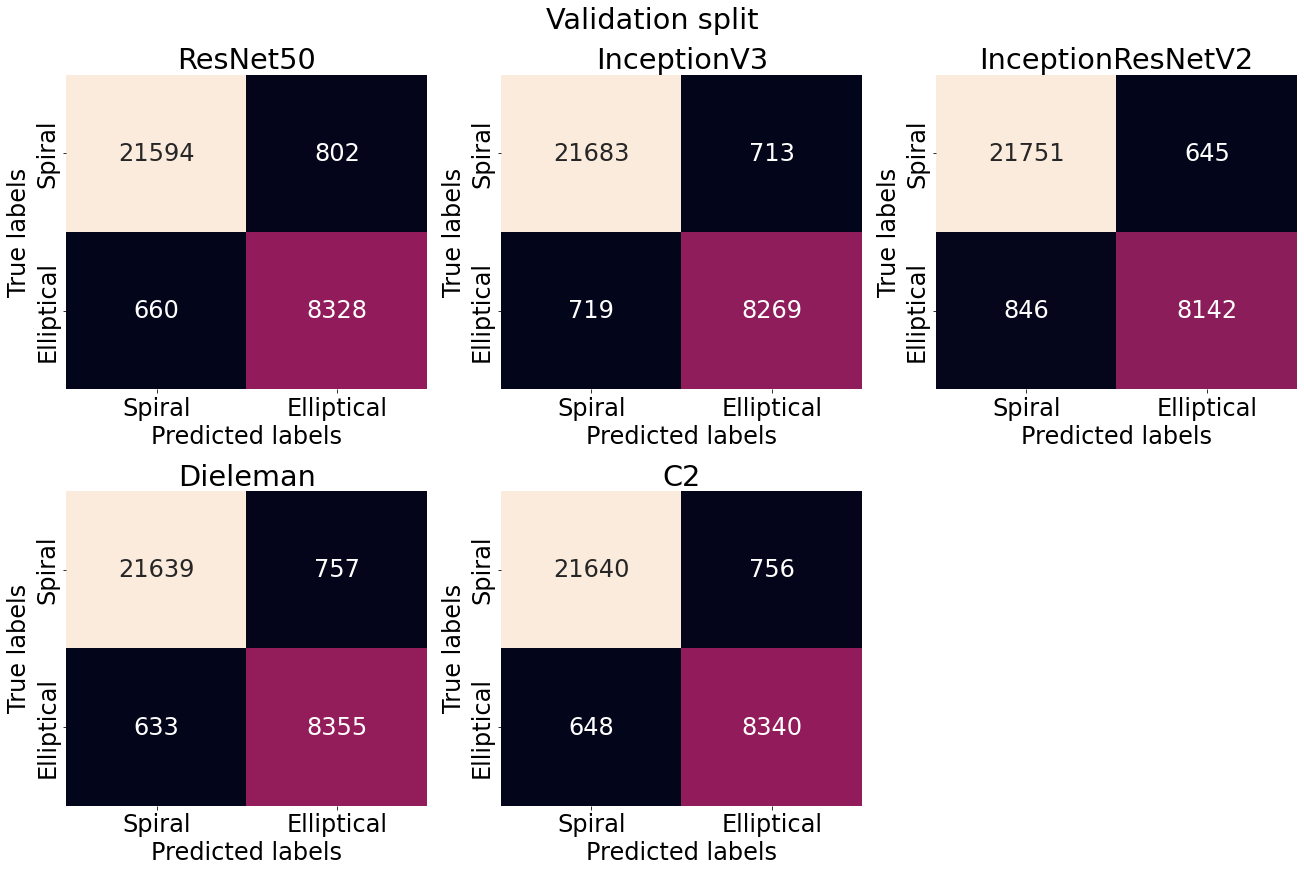

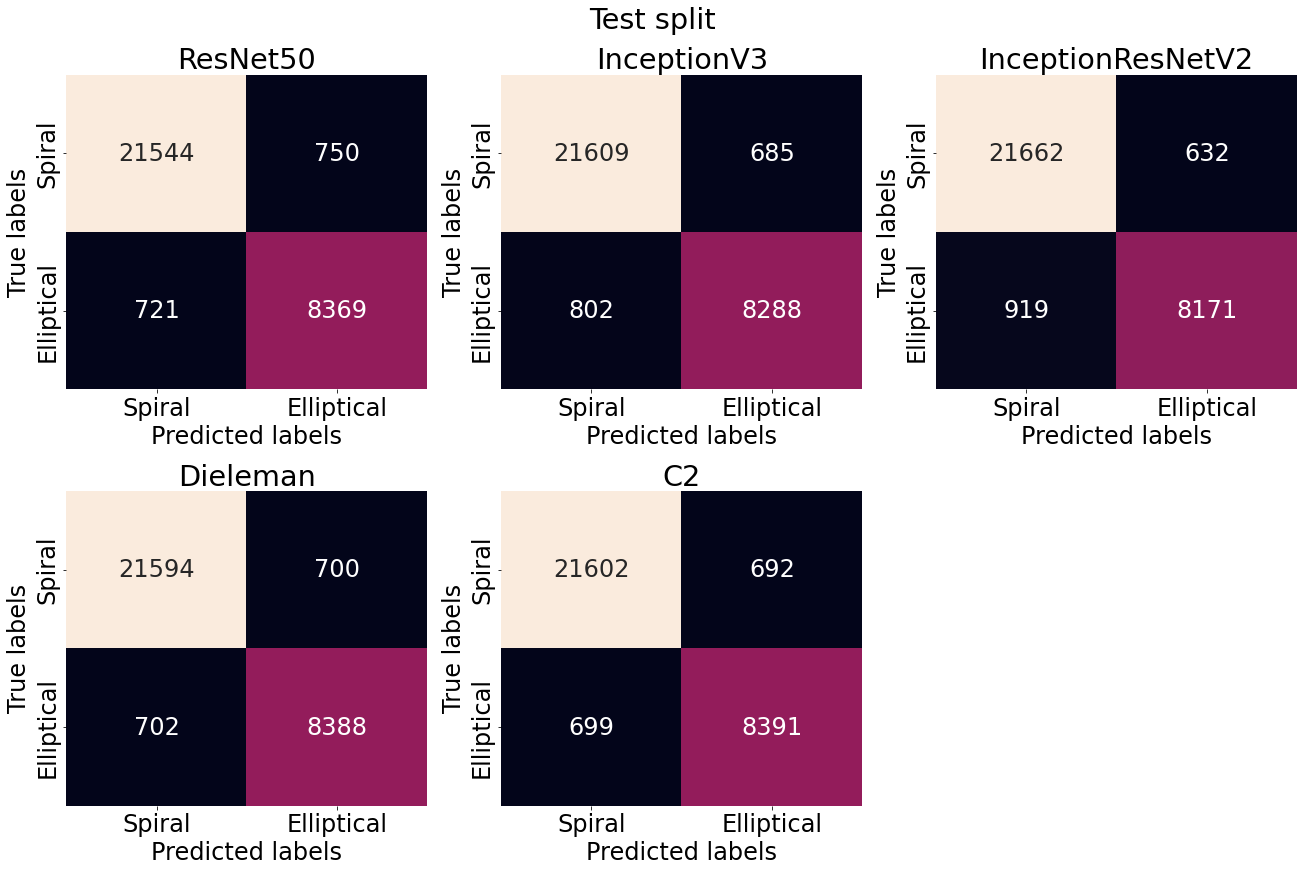

In [ ]:
import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'serif',
        'serif': ['Times'],
        'weight': 'normal'}

matplotlib.rc('font', **font)
matplotlib.rcParams.update({
    "text.usetex": False,
    'font.size' : 24,
    'axes.labelsize': 24,
    'legend.fontsize': 24
})

matrices = [    
    {
        "model": "ResNet50",
        "validation": [[21594, 802], [660, 8328]],
        "test": [[21544, 750], [721, 8369]]
    },
    {
        "model": "InceptionV3",
        "validation": [[21683, 713], [719, 8269]],
        "test": [[21609, 685], [802, 8288]]
    },
    {
        "model": "InceptionResNetV2",
        "validation": [[21751, 645], [846, 8142]],
        "test": [[21662, 632], [919, 8171]]
    },
    {
        "model": "Dieleman",
        "validation": [[21639, 757], [633, 8355]],
        "test": [[21594, 700], [702, 8388]]
    },
    {
        "model": "C2",
        "validation": [[21640, 756], [648, 8340]],
        "test": [[21602, 692], [699, 8391]]
    },
]


def plot_matrices(split):
  f, axarr = plt.subplots(2, 3, constrained_layout=True)

  f.set_figwidth(18)
  f.set_figheight(12)

  f.suptitle(f"{split.capitalize()} split")

  for i, obj in enumerate(matrices):
    df = pd.DataFrame(np.array(obj[split]), index = ['Spiral', 'Elliptical'], columns = ['Spiral', 'Elliptical'])
    sn.heatmap(df, annot=True, fmt='g', cbar=False, ax=axarr[i // 3][i % 3])
    axarr[i // 3][i % 3].set_ylabel("True labels")
    axarr[i // 3][i % 3].set_xlabel("Predicted labels")
    axarr[i // 3][i % 3].set_title(obj["model"])

  axarr[-1, -1].axis('off')
  # f.tight_layout()
  f.savefig(f"confusion_matrix_{split}.png")

plot_matrices("validation")
plot_matrices("test")

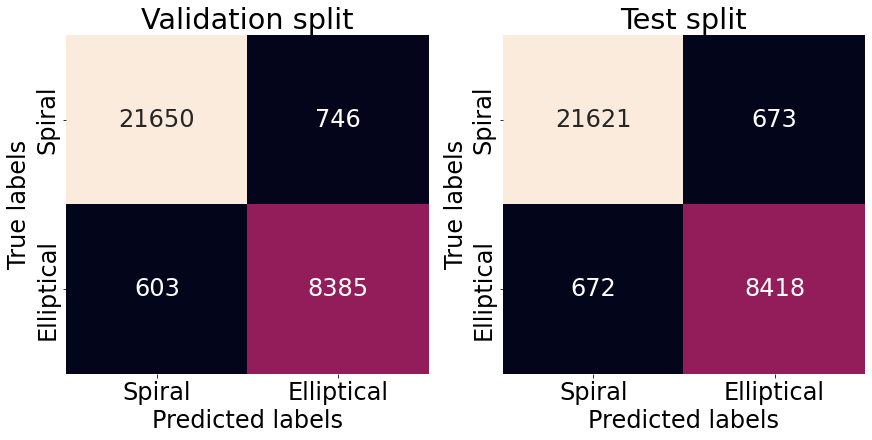

In [ ]:
import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'serif',
        'serif': ['Times'],
        'weight': 'normal'}

matplotlib.rc('font', **font)
matplotlib.rcParams.update({
    "text.usetex": False,
    'font.size' : 24,
    'axes.labelsize': 24,
    'legend.fontsize': 24
})

matrices = [    
    {
        "model": "Validation split",
        "matrix": [[21650, 746], [603, 8385]]
    },
    {
        "model": "Test split",
        "matrix": [[21621, 673], [672, 8418]]
    },
]
f, axarr = plt.subplots(1, 2, constrained_layout=True)

f.set_figwidth(12)
f.set_figheight(6)

for i, obj in enumerate(matrices):
  df = pd.DataFrame(np.array(obj["matrix"]), index = ['Spiral', 'Elliptical'], columns = ['Spiral', 'Elliptical'])
  sn.heatmap(df, annot=True, fmt='g', cbar=False, ax=axarr[i])
  axarr[i].set_ylabel("True labels")
  axarr[i].set_xlabel("Predicted labels")
  axarr[i].set_title(obj["model"])


# f.tight_layout()
# plt.show()
f.savefig("confusion_matrix_ensemble.png")